# Imputação de Dados

### Autor: André Rizzo


Notebook para enriquecimento de dados via Open Library API

### Carregar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Adiciona a raiz do projeto ao sys.path
sys.path.append(os.path.abspath(".."))

# Import do módulo de imputação
from src.preprocessing.data_imputation import (
    executar_pipeline_imputacao,
    identificar_registros_faltantes,
    executa_imputacao,
    aplicar_imputacoes
)

### Carregar Datasets Processados

In [15]:
# Carregar dados já processados do EDA
books_data = pd.read_parquet('../data/processed/books_data_processed.parquet')
books_rating = pd.read_parquet('../data/processed/books_rating_processed.parquet')

print("   Datasets carregados:")
print(f"   books_data: {books_data.shape}")
print(f"   books_rating: {books_rating.shape}")

   Datasets carregados:
   books_data: (12922, 15)
   books_rating: (299748, 10)


In [16]:
books_data.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Title_padrao,authors_padrao,publisher_padrao,categories_padrao,publishedDate_padrao
0,License to Laugh,"Grade level: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11...",['Richard A. Shade'],http://books.google.com/books/content?id=VuNX4...,http://books.google.com/books?id=VuNX4Sql51oC&...,Libraries Unlimited,1996-01-01,https://play.google.com/store/books/details?id...,['Education'],2.0,License to Laugh,richard a. shade,libraries unlimited,education,1996.0
1,Motown and Didi (Polk Street Special),"Motown and Didi, two teenage loners in Harlem,...",['Walter Dean Myers'],http://books.google.com/books/content?id=qcbXA...,http://books.google.nl/books?id=qcbXAAAAMAAJ&q...,Laurel Leaf,1987-01-01,http://books.google.nl/books?id=qcbXAAAAMAAJ&d...,['Juvenile Fiction'],1.0,Motown and Didi (Polk Street Special),walter dean myers,laurel leaf,juvenile fiction,1987.0
2,The FBI-KGB War: A Special Agent's Story,"The names, we sometimes say, have been changed...","['Robert J. Lamphere', 'Tom Shachtman']",http://books.google.com/books/content?id=IB_Sh...,http://books.google.com/books?id=IB_ShD9fTcsC&...,Mercer University Press,1995-01-01,https://play.google.com/store/books/details?id...,['History'],1.0,The FBI-KGB War: A Special Agent's Story,"robert j. lamphere, tom shachtman",mercer university press,history,1995.0
3,Captain Cook's World: Maps of the Life and Voy...,"James Cook, sailor, surveyor, cartographer, an...",['John Robson'],http://books.google.com/books/content?id=7udsQ...,http://books.google.com/books?id=7udsQgAACAAJ&...,Seattle : University of Washington Press,2000-01-01,http://books.google.com/books?id=7udsQgAACAAJ&...,['Reference'],1.0,Captain Cook's World: Maps of the Life and Voy...,john robson,seattle university of washington press,reference,2000.0
4,Mary Magdalene: A Biography,Explores Mary Magdalene's key role in the mini...,['Bruce Chilton'],http://books.google.com/books/content?id=d7feX...,http://books.google.com/books?id=d7feX5LOMfoC&...,Image Books,2006-01-01,http://books.google.com/books?id=d7feX5LOMfoC&...,['Biography & Autobiography'],2.0,Mary Magdalene: A Biography,bruce chilton,image books,biography & autobiography,2006.0


### Análise de Dados Faltantes

In [16]:
# Verificar dados faltantes antes da imputação
print("Análise de dados faltantes ANTES da imputação:")
print("=" * 50)

campos_alvo = ['authors_padrao', 'publisher_padrao', 'categories_padrao', 'publishedDate_padrao']

for campo in campos_alvo:
    total = len(books_data)
    faltantes = books_data[campo].isna().sum()
    percentual = (faltantes / total) * 100
    print(f"{campo:20}: {faltantes:6,} ({percentual:5.1f}%)")

Análise de dados faltantes ANTES da imputação:
authors_padrao      :  2,292 ( 17.7%)
publisher_padrao    :  4,082 ( 31.6%)
categories_padrao   :  2,386 ( 18.5%)
publishedDate_padrao:  6,833 ( 52.9%)


### Identificar Registros para Imputação

In [20]:
titulos_para_buscar = identificar_registros_faltantes(books_data)

print(f"Registros identificados para imputação: {len(titulos_para_buscar):,}")
print(f"Isso representa {len(titulos_para_buscar)/len(books_data)*100:.1f}% do dataset")

# Mostrar alguns exemplos
print("\n Exemplos de títulos que serão processados:")
for i, (idx, titulo) in enumerate(titulos_para_buscar[:5]):
    print(f"   {i+1}. [{idx}] {titulo}")

Registros identificados para imputação: 8,828
Isso representa 68.3% do dataset

 Exemplos de títulos que serão processados:
   1. [3668] The Hoosier School-Master
   2. [3669] The Ginger Man
   3. [3670] Cooking 1-2-3: 500 Fabulous Three-Ingredient Recipes (1-2-3 Cookbook)
   4. [3671] Backyard Rescue
   5. [3672] Calvin's commentaries


### Execução da Imputação

**Configurações para PoC:**
- Checkpoint a cada 100 registros

In [18]:
# Configurações da imputação
LIMITE_REGISTROS = 13000  # Para PoC - ajustar conforme necessário
MAX_WORKERS = 40        # Threads paralelas
OUTPUT_DIR = "../data/modified/"

print("   Configurações da imputação:")
print(f"   Limite de registros: {LIMITE_REGISTROS:,}")
print(f"   Threads paralelas: {MAX_WORKERS}")
print(f"   Diretório de saída: {OUTPUT_DIR}")

   Configurações da imputação:
   Limite de registros: 13,000
   Threads paralelas: 40
   Diretório de saída: ../data/modified/


### Execução do Pipeline Completo

In [21]:
books_data_imputado = executar_pipeline_imputacao(
    books_data=books_data,
    limite=LIMITE_REGISTROS,
    max_workers=MAX_WORKERS,
    output_dir=OUTPUT_DIR
)

Iniciando pipeline de imputação...
Limpando strings vazias nos campos padronizados...
Limpando strings vazias...
Identificando registros com dados faltantes...
   Encontrados 8828 registros com dados faltantes
Iniciando processo de imputação via Open Library...
Iniciando imputação de 8828 registros com 40 threads...


Paralelizando requisições: 100%|██████████| 8828/8828 [03:04<00:00, 47.90it/s]


Relatório de Imputação:
Tempo total: 184.98 segundos
Registros processados: 8828

   authors_padrao
   - Ausentes antes : 2292
   - Imputados      : 18
   - Permaneceram NA: 2274
   - Taxa de sucesso: 0.79%

   publisher_padrao
   - Ausentes antes : 4082
   - Imputados      : 18
   - Permaneceram NA: 4064
   - Taxa de sucesso: 0.44%

   categories_padrao
   - Ausentes antes : 2386
   - Imputados      : 15
   - Permaneceram NA: 2371
   - Taxa de sucesso: 0.63%

   publishedDate_padrao
   - Ausentes antes : 6833
   - Imputados      : 18
   - Permaneceram NA: 6815
   - Taxa de sucesso: 0.26%

Aplicando imputações ao dataset original...
Dataset imputado salvo em: ../data/modified/books_data_imputado.parquet


### Análise dos Resultados

In [17]:
# Comparar dados faltantes antes e depois
print(" COMPARAÇÃO: Antes vs Depois da Imputação")
print("=" * 60)

for campo in campos_alvo:
    antes = books_data[campo].isna().sum()
    depois = books_data_imputado[campo].isna().sum()
    imputados = antes - depois
    taxa_sucesso = (imputados / antes) * 100 if antes > 0 else 0
    
    print(f"\n {campo}:")
    print(f"   Antes     : {antes:6,} valores faltantes")
    print(f"   Depois    : {depois:6,} valores faltantes") 
    print(f"   Imputados : {imputados:6,} valores")
    print(f"   Taxa      : {taxa_sucesso:6.1f}% de sucesso")

 COMPARAÇÃO: Antes vs Depois da Imputação

 authors_padrao:
   Antes     :  2,292 valores faltantes
   Depois    :  2,292 valores faltantes
   Imputados :      0 valores
   Taxa      :    0.0% de sucesso

 publisher_padrao:
   Antes     :  4,082 valores faltantes
   Depois    :  4,081 valores faltantes
   Imputados :      1 valores
   Taxa      :    0.0% de sucesso

 categories_padrao:
   Antes     :  2,386 valores faltantes
   Depois    :  2,386 valores faltantes
   Imputados :      0 valores
   Taxa      :    0.0% de sucesso

 publishedDate_padrao:
   Antes     :  6,833 valores faltantes
   Depois    :  6,813 valores faltantes
   Imputados :     20 valores
   Taxa      :    0.3% de sucesso


### Verificação da Qualidade

In [12]:
# Verificar qualidade das imputações
print(" VERIFICAÇÃO DE QUALIDADE")
print("=" * 40)

# Amostrar alguns registros imputados para verificação manual
indices_imputados = books_data_imputado.index[
    books_data['authors_padrao'].isna() & 
    books_data_imputado['authors_padrao'].notna()
].tolist()

if indices_imputados:
    print(f"Exemplos de autores imputados ({len(indices_imputados)} total):")
    for idx in indices_imputados[:5]:
        titulo = books_data_imputado.loc[idx, 'Title_padrao']
        autor_imputado = books_data_imputado.loc[idx, 'authors_padrao']
        print(f"   {titulo}")
        print(f"      Autor imputado: {autor_imputado}\n")

 VERIFICAÇÃO DE QUALIDADE


### Análise Estatística

In [8]:
# Estatísticas descritivas dos anos imputados
anos_imputados = books_data_imputado[
    books_data['publishedDate_padrao'].isna() & 
    books_data_imputado['publishedDate_padrao'].notna()
]['publishedDate_padrao']

if not anos_imputados.empty:
    print("ESTATÍSTICAS DOS ANOS IMPUTADOS")
    print("=" * 40)
    print(f"Total de anos imputados: {len(anos_imputados)}")
    print(f"Ano mais antigo: {anos_imputados.min():.0f}")
    print(f"Ano mais recente: {anos_imputados.max():.0f}")
    print(f"Mediana: {anos_imputados.median():.0f}")

ESTATÍSTICAS DOS ANOS IMPUTADOS
Total de anos imputados: 20
Ano mais antigo: 1505
Ano mais recente: 2014
Mediana: 2001


### Visualização dos Resultados

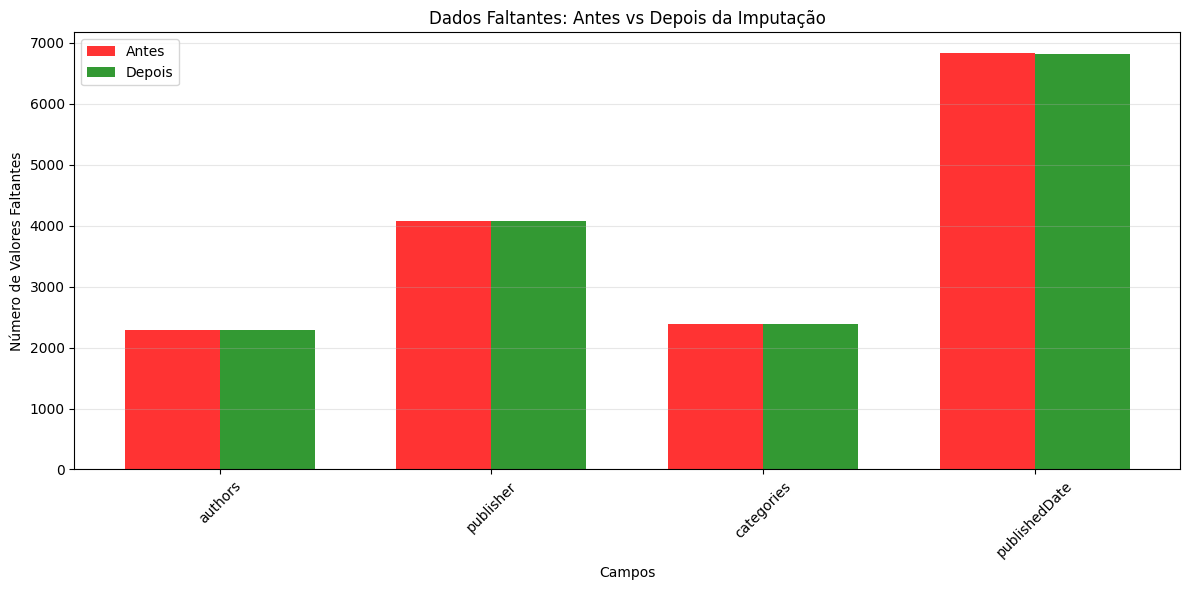

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras: antes vs depois
fig, ax = plt.subplots(figsize=(12, 6))

dados_plot = []
for campo in campos_alvo:
    antes = books_data[campo].isna().sum()
    depois = books_data_imputado[campo].isna().sum()
    dados_plot.append({'Campo': campo.replace('_padrao', ''), 'Antes': antes, 'Depois': depois})

df_plot = pd.DataFrame(dados_plot)

x = range(len(df_plot))
width = 0.35

ax.bar([i - width/2 for i in x], df_plot['Antes'], width, label='Antes', alpha=0.8, color='red')
ax.bar([i + width/2 for i in x], df_plot['Depois'], width, label='Depois', alpha=0.8, color='green')

ax.set_xlabel('Campos')
ax.set_ylabel('Número de Valores Faltantes')
ax.set_title('Dados Faltantes: Antes vs Depois da Imputação')
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Campo'], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Salvar Datasets Finais

In [ ]:
# Salvar datasets finais em diferentes formatos
output_files = {
    'parquet': '../data/final/books_data_final.parquet',
    'csv': '../data/final/books_data_final.csv'
}

# Criar diretório se não existe
os.makedirs('../data/final/', exist_ok=True)

# Salvar em múltiplos formatos
for formato, caminho in output_files.items():
    if formato == 'parquet':
        books_data_imputado.to_parquet(caminho, index=False)
    else:
        books_data_imputado.to_csv(caminho, index=False)
    
    print(f" Dataset salvo em {formato.upper()}: {caminho}")

### Relatório Final

In [10]:
print("RELATÓRIO FINAL DA IMPUTAÇÃO")
print("=" * 50)
print(f" Dataset original: {books_data.shape[0]:,} registros")
print(f" Registros processados: {min(LIMITE_REGISTROS, len(titulos_para_buscar)):,}")
print(f" Campos melhorados: {len(campos_alvo)}")

total_imputacoes = 0
for campo in campos_alvo:
    antes = books_data[campo].isna().sum()
    depois = books_data_imputado[campo].isna().sum()
    imputacoes = antes - depois
    total_imputacoes += imputacoes

print(f" Total de imputações realizadas: {total_imputacoes:,}")
print(f" Dataset final salvo com {books_data_imputado.shape[0]:,} registros")

# Calcular melhoria geral
missing_antes = books_data[campos_alvo].isna().sum().sum()
missing_depois = books_data_imputado[campos_alvo].isna().sum().sum()
melhoria_percentual = ((missing_antes - missing_depois) / missing_antes) * 100

print(f" Melhoria geral: {melhoria_percentual:.1f}% redução em dados faltantes")

RELATÓRIO FINAL DA IMPUTAÇÃO
 Dataset original: 12,922 registros
 Registros processados: 8,828
 Campos melhorados: 4
 Total de imputações realizadas: 21
 Dataset final salvo com 12,922 registros
 Melhoria geral: 0.1% redução em dados faltantes
